In [1]:
import requests
import torch
from PIL import Image
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

import os


In [2]:
images_dir = '/home/ubuntu/workspace/datasets/ab_car_validation_germany/images'
images = ['1662977029898881.png', '1662977474971772.png', '1662979976537397.png', '1662986855594397.png', '1662987183598729.png']
image_paths = [os.path.join(images_dir, image) for image in images if os.path.exists(os.path.join(images_dir, image))]
image_paths

['/home/ubuntu/workspace/datasets/ab_car_validation_germany/images/1662977029898881.png',
 '/home/ubuntu/workspace/datasets/ab_car_validation_germany/images/1662977474971772.png',
 '/home/ubuntu/workspace/datasets/ab_car_validation_germany/images/1662979976537397.png',
 '/home/ubuntu/workspace/datasets/ab_car_validation_germany/images/1662986855594397.png',
 '/home/ubuntu/workspace/datasets/ab_car_validation_germany/images/1662987183598729.png']

In [24]:
image_path = image_paths[2]

In [25]:
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-cityscapes-semantic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-cityscapes-semantic")
image = Image.open(image_path)
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits
panoptic_results = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])


`label_ids_to_fuse` unset. No instance will be fused.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import torch.nn.functional as F


probabilities = F.softmax(class_queries_logits, dim=-1)
top_prob, top_class_id = probabilities.topk(1, dim=-1)
id2label = model.config.id2label
top_labels = [id2label.get(class_id.item()) for class_id in top_class_id.squeeze()]


In [5]:
# Cityscapes colormap
cityscapes_colors = [
    [128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156], [190, 153, 153],
    [153, 153, 153], [250, 170, 30], [220, 220, 0], [107, 142, 35], [152, 251, 152],
    [70, 130, 180], [220, 20, 60], [255, 0, 0], [0, 0, 142], [0, 0, 70],
    [0, 60, 100], [0, 80, 100], [0, 0, 230], [119, 11, 32]
]

# Cityscapes labels
cityscapes_labels = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle'
]

In [ ]:
panoptic_entry = panoptic_results[0]
panoptic_map = panoptic_entry['segmentation'].cpu().numpy()

unique_ids = np.unique(panoptic_map)
num_instances = len(unique_ids)

colors = cityscapes_colors + [list(np.random.randint(0, 255, size=3)) for _ in range(num_instances - len(cityscapes_colors))]

h, w = panoptic_map.shape
rgb_output = np.zeros((h, w, 3), dtype=np.uint8)

for idx, uid in enumerate(unique_ids):
    rgb_output[panoptic_map == uid] = colors[idx]

segments_info = panoptic_entry['segments_info']

detected_labels = [cityscapes_labels[seg_info['id']] if seg_info['id'] < len(cityscapes_labels) else f"Instance {seg_info['id']-len(cityscapes_labels)}" for seg_info in segments_info]
detected_colors = [colors[i] for i in range(len(unique_ids))]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(rgb_output)
ax.set_title("Panoptic Segmentation with Contours")

for uid in unique_ids:
    contours = measure.find_contours(panoptic_map == uid, 0.1)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='black')

legend_patches = [
    plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=np.array(color)/255.0) 
    for color, label in zip(detected_colors, detected_labels)
]
ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

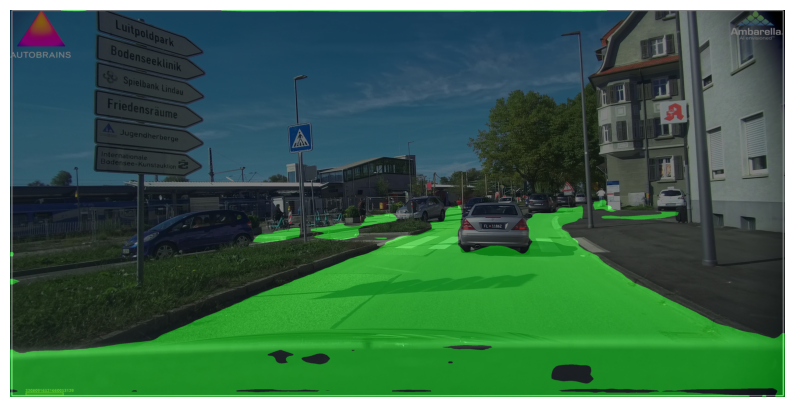

In [23]:
panoptic_entry = panoptic_results[0]
panoptic_map = panoptic_entry['segmentation'].cpu().numpy()

road_class_id = cityscapes_labels.index('road')

road_segments = [segment for segment in panoptic_entry['segments_info'] if segment['label_id'] == road_class_id]

road_mask = np.zeros_like(panoptic_map, dtype=np.uint8)
for segment in road_segments:
    road_mask[panoptic_map == segment['id']] = 1

image_array = np.array(image)
overlay = (image_array * 0.5 + np.array([0, 120, 0]) * 0.9 * np.expand_dims(road_mask, -1)).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.imshow(overlay)
plt.axis('off')
plt.show()


In [ ]:
print(panoptic_entry['segments_info'][0])
